# 🧠 RECONHECIMENTO DE EMOÇÕES FACIAIS COM VGG19  
### *Uma Análise Comparativa com Abordagens Convencionais*

---

## 📝 Autoria  
**Autor:**  
🔹 Igor Cenzi dos Santos Alves  
📧 *igor.alves@sou.fae.br*  

**Orientadora:**  
🔹 Profª. Cristiane Yae Mi Imamura  
📧 *cristiane.imamura@prof.fae.br*  

**Instituição:**  
🏫 FAE Centro Universitário  

---

## 🎯 Objetivo  
Desenvolver um modelo de reconhecimento de emoções faciais com performance otimizada, comparando a abordagem com redes neurais profundas (VGG19) contra métodos convencionais de machine learning.

**Principais métricas de avaliação:**  
- Acurácia  
- Precisão  
- Recall  
- F1-Score  

---

## 📦 Materiais & Recursos  
### Bases de Dados  
🔹 **FER-2013**  
[![Kaggle](https://img.shields.io/badge/-Kaggle-20BEFF?logo=kaggle&logoColor=white)](https://www.kaggle.com/datasets/msambare/fer2013)  
- 35,887 imagens de expressões faciais  
- 7 classes de emoções (Raiva, Nojo, Medo, Feliz, Neutro, Triste, Surpreso)  
- Resolução 48×48 pixels (grayscale)  

### Modelos  
🔹 **VGG19** (Transfer Learning)  
[![Keras](https://img.shields.io/badge/-Keras-D00000?logo=keras&logoColor=white)](https://keras.io/api/applications/vgg/)  
- Arquitetura CNN pré-treinada no ImageNet  
- 19 camadas profundas  

---

## 📌 Checklist de Atividades  

| Status | Tarefa | Detalhes |
|--------|--------|----------|
| ✅ | Importação de bibliotecas | `TensorFlow`, `Keras`, `OpenCV`, `Pandas` |
| ✅ | Download do dataset FER-2013 | Carregamento via Kaggle API |
| ✅ | Leitura dos dados de treino e teste | Kaggle |
| ✅ | Exploração do dataset | Análise de distribuição de classes |
| 🔄 | Limpeza de dados | Removendo imagens sem rostos |
| ⏳ | Testes iniciais VGG19 | Baseline sem pré-processamento |
| ❌ | Visualização de métricas | Gráficos de acurácia/loss |
| ❌ | Conclusões parciais | Comparativo inicial |

---

## 🔍 Próximos Passos  
1. **Pré-processamento avançado**  
   - Equalização de histograma  
   - Data augmentation (rotação, flip)  

2. **Fine-tuning do VGG19**  
   - Congelamento de camadas  
   - Ajuste de hiperparâmetros  

3. **Benchmark** contra:  
   - SVM
   - KNN 
   - CNN customizada  


## 1. Importação de bibliotecas que serão utilizadas no projeto

In [7]:
import numpy as np
import pandas as pd
import os
import zipfile
import shutil
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imutils import face_utils
import dlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import kagglehub
from IPython.display import display, Markdown

import warnings
warnings.filterwarnings('ignore')


## 2. Download do dataset FER-2013

O download é feito utilizando a biblioteca kagglehub e as imagens são salvas no diretório de destino DESTINATION_PATH

In [8]:
DESTINATION_PATH = "./fer2013"
kaggle_path = kagglehub.dataset_download("msambare/fer2013")

if not os.path.exists(DESTINATION_PATH):
    shutil.copytree(kaggle_path, DESTINATION_PATH)

print("Dataset copiado para:", DESTINATION_PATH)

Dataset copiado para: ./fer2013


## 3. Carregando os dados baixados para a memória

Com os dados salvos, o próximo passo é fazer a leitura para a memória e adicionar a label dos dados

In [10]:
TRAIN_PATH = os.path.join(DESTINATION_PATH, "train")
TEST_PATH = os.path.join(DESTINATION_PATH, "test")

def load_images_and_labels(DATA_PATH):
    images = []
    labels = []
    class_names = sorted(os.listdir(DATA_PATH))
    label_map = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(DATA_PATH, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(label_map[class_name])

    return np.array(images), np.array(labels), label_map

X_train, y_train, label_map = load_images_and_labels(TRAIN_PATH)
X_test, y_test, _ = load_images_and_labels(TEST_PATH)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)
print("Labels mapeadas:", label_map)

Train: (28709, 48, 48, 3) (28709,)
Test: (7178, 48, 48, 3) (7178,)
Labels mapeadas: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# 4. Explorando o dataset

## 4.1. Visualizando algumas imagens de cada uma das 7 classes do dataset

### Angry:

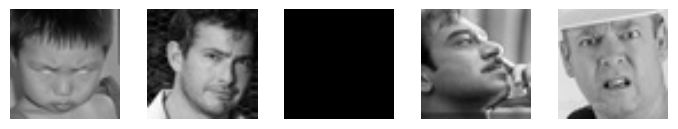

### Disgust:

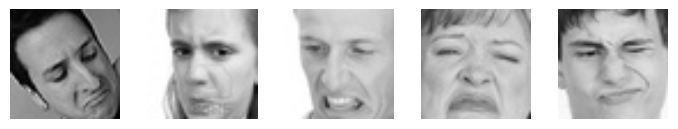

### Fear:

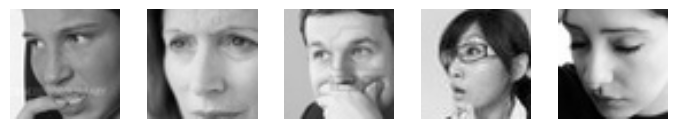

### Happy:

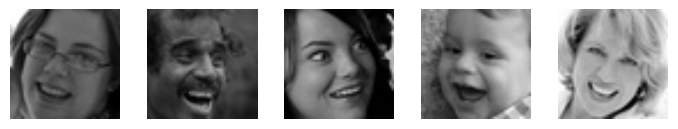

### Neutral:

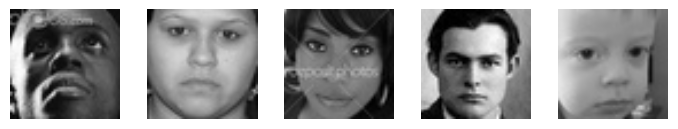

### Sad:

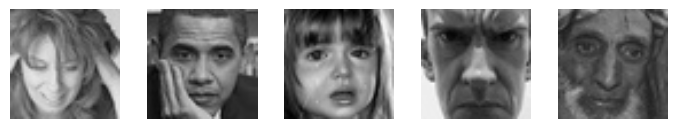

### Surprise:

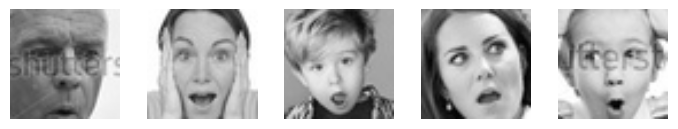

In [11]:
inv_label_map = {v: k for k, v in label_map.items()}

samples_per_class = 5
classes = sorted(np.unique(y_train))
selected_images = {label: [] for label in classes}

for img, label in zip(X_train, y_train):
    if len(selected_images[label]) < samples_per_class:
        selected_images[label].append(img)
    if all(len(imgs) == samples_per_class for imgs in selected_images.values()):
        break

for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name}:"))

    fig, axes = plt.subplots(1, samples_per_class, figsize=(samples_per_class * 1.4, 1.4))
    for i in range(samples_per_class):
        img_rgb = cv2.cvtColor(selected_images[label][i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb, interpolation='bilinear')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## 🕵️‍♂️ Análise Exploratória - Limitações do Dataset

Durante a inspeção inicial do **FER-2013**, identificamos um desafio crítico para modelos de reconhecimento facial:

### Problema: Amostras Não-Úteis
🔴 **Caso exemplar** (imagem abaixo):  
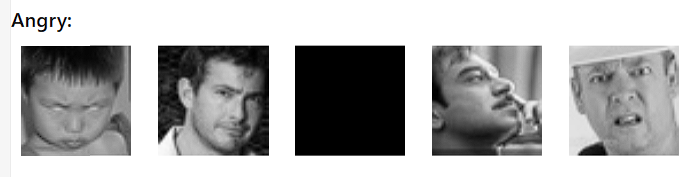  
*Figura 1: Instância do dataset sem conteúdo facial discernível - rótulo original: "Angry"*

## 📊 4.2 Análise de Distribuição de Classes: Treino

### Distribuição Percentual Comparativa

**Principais Observações:**
 **Desbalanceamento Característico**  
   - Classe predominante: Happy (25.13%)  
   - Classes minoritárias:  
     - Disgust (1.54%)  
     - Surprise (11.05%)  

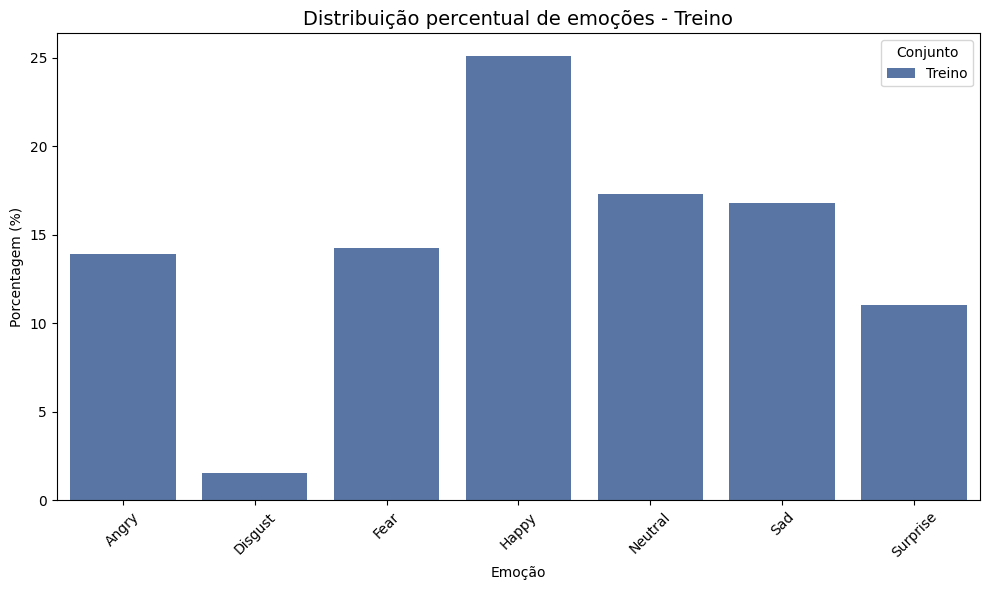

In [16]:
def get_distribution(labels):
    count_series = pd.Series(labels).value_counts().sort_index()
    count_df = pd.DataFrame({
        'Emoção': [inv_label_map[i].capitalize() for i in count_series.index],
        'Quantidade': count_series.values,
    })
    total = count_df['Quantidade'].sum()
    count_df['Porcentagem'] = (count_df['Quantidade'] / total * 100).round(2)
    return count_df

df_train = get_distribution(y_train)

df_train['Conjunto'] = 'Treino'

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Emoção',
    y='Porcentagem',
    hue='Conjunto',
    palette=['#4C72B0', '#55A868']
)

plt.title("Distribuição percentual de emoções - Treino", fontsize=14)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Emoção")
plt.xticks(rotation=45)
plt.legend(title="Conjunto")
plt.tight_layout()
plt.show()

# ⚠️ Impactos do Desbalanceamento de Classes

## Principais Problemas

### 1. 📈 Acurácia Ilusória
- Modelos atingem alta acurácia apenas prevendo classes majoritárias
- Exemplo: 90% de acurácia quando 90% dos dados são de uma só classe

### 2. 🎯 Viés de Predição
- Classes minoritárias são sistematicamente negligenciadas
- Baixo recall para emoções raras

### 3. 📊 Distorção Métrica
- Métricas globais (F1-macro) mascaram desempenho ruim em classes específicas
- Precisão desigual entre classes

## 5. Limpando o dataset

Conforme observado na etapa anterior, algumas imagens estão completamente pretas, ou seja, sem nenhum rosto para detectar. A função abaixo executa a limpeza desse dataset em memória.

In [51]:
from tqdm import tqdm

def remove_black_images(images, labels):
    valid_indices = []
    progress_bar = tqdm(enumerate(images), total=len(images), desc="Removendo imagens pretas")
    
    for i, img in progress_bar:
        if np.any(img > 0):
            valid_indices.append(i)

    filtered_images = images[valid_indices]
    filtered_labels = labels[valid_indices]

    print(f"\nRemoção concluída. {len(filtered_images)}/{len(images)} imagens mantidas.")
    print(f"Distribuição das classes após remoção: {np.unique(filtered_labels, return_counts=True)}")

    return filtered_images, filtered_labels


In [52]:
X_train_filtered, y_train_filtered = remove_black_images(X_train, y_train)

Removendo imagens pretas: 100%|██████████| 28709/28709 [00:00<00:00, 194745.84it/s]


Remoção concluída. 28698/28709 imagens mantidas.
Distribuição das classes após remoção: (array([0, 1, 2, 3, 4, 5, 6]), array([3988,  436, 4097, 7214, 4964, 4829, 3170], dtype=int64))


In [57]:
qtd_removidas = X_train.shape[0] - X_train_filtered.shape[0]
print(f"Foram removidas {qtd_removidas} imagens.")

Foram removidas 11 imagens.


## 6. Pré-processamento de Imagens de treino para o VGG19

### 📌 **Objetivo**  
- Preparar as imagens do dataset para compatibilidade com a arquitetura VGG19, seguindo os mesmos padrões utilizados no treinamento original no ImageNet.
- Para as labels, é utilizado a técnica de OneHot Encoding, a qual transforma uma saída única em um array com todas as possíveis classes, indicando 1 para a classe que é a correta e 0 para as demais.

In [82]:
def prepare_images(images):
    processed_images = []
    
    for img in images:
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 1:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LANCZOS4)
        
        img_processed = preprocess_input(img_resized)
        processed_images.append(img_processed)
    
    return np.array(processed_images)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input

X_train_preprocessed = prepare_images(X_train_filtered)
y_train_preprocessed = to_categorical(y_train_filtered)

## 7. Definição de modelo inicial VGG19

In [ ]:
from keras.applications import VGG19
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

IMG_HEIGHT, IMG_WIDTH = 48, 48
NUM_CLASSES = 7

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


## 7. Funções para a pipeline

O próximo passo é escrever funções para o pré processamento das imagens, para criar uma pipeline que irá ser utilizada para processar as imagens antes do modelo prever o resultado.
Isso ajuda a garantir que as imagens de treino terão as mesmas condições das imagens de produção.

In [12]:
def to_rgb(image):
    """Converte imagem para RGB se estiver em grayscale."""
    if len(image.shape) == 2 or image.shape[2] == 1:
        return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

In [13]:
# Carrega o classificador HaarCascade frontal padrão (incluso no OpenCV)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detect_and_crop_face(image, scaleFactor=1.1, minNeighbors=5):
    """Detecta o rosto e retorna apenas a região do rosto. Se não detectar, retorna a imagem original."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    if len(faces) == 0:
        return image  # Nenhum rosto encontrado

    # Pega a maior detecção (mais comum em fotos reais com um rosto só)
    x, y, w, h = max(faces, key=lambda box: box[2] * box[3])
    cropped = image[y:y+h, x:x+w]
    return cropped


In [14]:
def resize_image(image, size=(224, 224)):
    """Redimensiona a imagem para o tamanho indicado."""
    return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)


In [15]:
def normalize_pixels(image):
    """Normaliza os valores de pixel para o intervalo [0, 1]."""
    return image.astype(np.float32) / 255.0


In [16]:
def equalize_histogram(image):
    """Aplica equalização de histograma nos 3 canais RGB separadamente."""
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    equalized = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return equalized


In [17]:
# Inicializar os detectores GLOBALMENTE (fora da função)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def align_face_landmarks(image, label=None):
    """Alinha o rosto usando pontos faciais com tratamento especial para ângulos próximos a 180°"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)

    if len(rects) == 0:
        return image

    rect = max(rects, key=lambda r: r.width() * r.height())
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    (lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]

    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX))

    # Ajuste especial para ângulos próximos a 180°
    if angle > 150:  # Consideramos como rotação invertida
        angle = angle - 180
    elif angle < -150:
        angle = angle + 180

    rotation_angle = angle  # Já ajustamos o ângulo

    if label is not None:
        print(f"Label: {label}, Original angle: {np.degrees(np.arctan2(dY, dX)):.2f}, Adjusted angle: {angle:.2f}, Rotation to apply: {rotation_angle:.2f}")

    if abs(rotation_angle) > 45:
        return image

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    aligned_image = cv2.warpAffine(image, rot_matrix, (w, h),
                                flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

    return aligned_image

## 7.1 Visualização das imagens rotacionadas
Aqui temos apenas uma visualização para comparar as imagens antes e depois do tratamento de rotação da face

In [18]:
# Aplica o alinhamento baseado em landmarks nas imagens selecionadas
aligned_images_landmarks = {}

for label in classes:
    aligned_images_landmarks[label] = []
    for img in selected_images[label]:
        emotion_name = inv_label_map[label].capitalize()
        aligned = align_face_landmarks(img, label=emotion_name)
        aligned_images_landmarks[label].append(aligned)

# Exibir original x rotacionado lado a lado
for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name} — Antes e Depois da Rotação (Landmarks):"))

    fig, axes = plt.subplots(2, samples_per_class, figsize=(samples_per_class * 2.5, 5))

    for i in range(samples_per_class):
        # Linha 1: Original
        original_img = cv2.cvtColor(selected_images[label][i], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(original_img, interpolation='bilinear')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)

        # Linha 2: Alinhado
        aligned_img = cv2.cvtColor(aligned_images_landmarks[label][i], cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(aligned_img, interpolation='bilinear')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel("Alinhado", fontsize=12)

    plt.tight_layout()
    plt.show()

NameError: name 'classes' is not defined

## 8. Criação de pipeline para tratamento das imagens

In [19]:
def preprocess_pipeline(image, apply_equalization=False):
    """
    Aplica a sequência completa de pré-processamento:
    1. Conversão para RGB
    2. Alinhamento baseado em landmarks (dlib)
    3. Detecção e recorte do rosto (HaarCascade)
    4. Redimensionamento para 224x224
    5. (Opcional) Equalização de histograma
    6. Normalização dos pixels para [0, 1]

    Retorna a imagem pronta para entrada na rede neural.
    """

    # 1. Garantir que está em RGB
    image = to_rgb(image)

    # 2. Alinhamento facial com landmarks
    image = align_face_landmarks(image)

    # 3. Recorte do rosto (HaarCascade)
    image = detect_and_crop_face(image)

    # 4. Redimensionamento
    image = resize_image(image, size=(224, 224))

    # 5. Equalização de histograma (opcional)
    if apply_equalization:
        image = equalize_histogram(image)

    # 6. Normalização
    image = normalize_pixels(image)

    return image

## 8.1 Visualização das imagens processadas
Aqui temos apenas uma visualização para comparar as imagens antes e depois da aplicação da pipeline

### Angry — Antes e Depois do Pré-processamento:

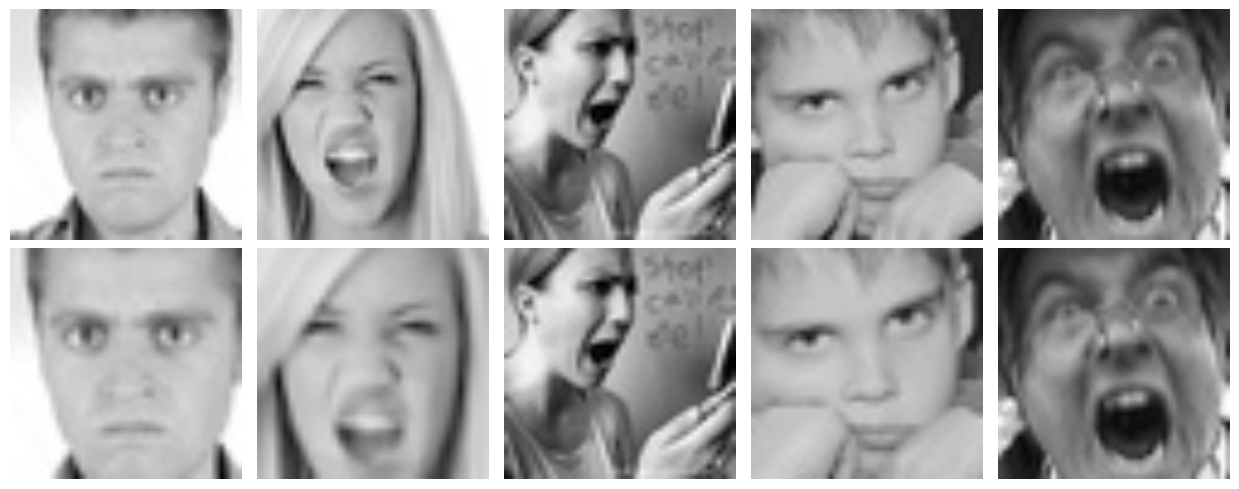

### Disgust — Antes e Depois do Pré-processamento:

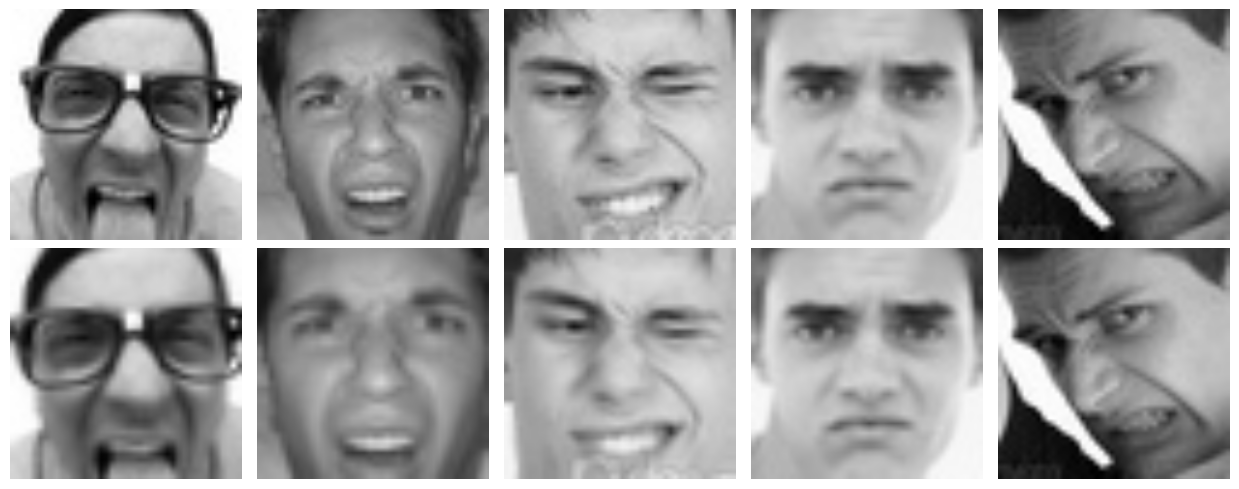

### Fear — Antes e Depois do Pré-processamento:

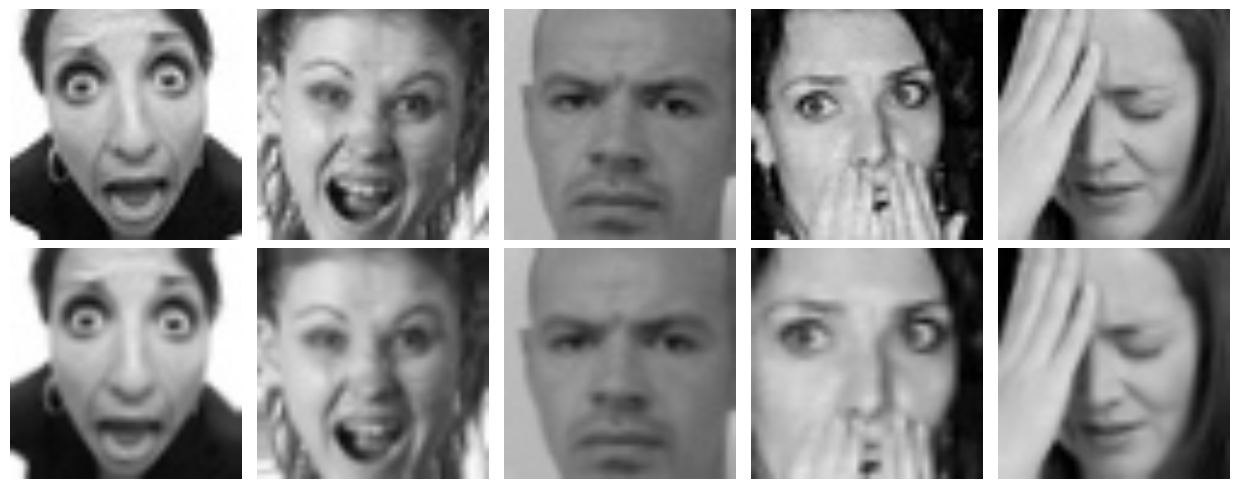

### Happy — Antes e Depois do Pré-processamento:

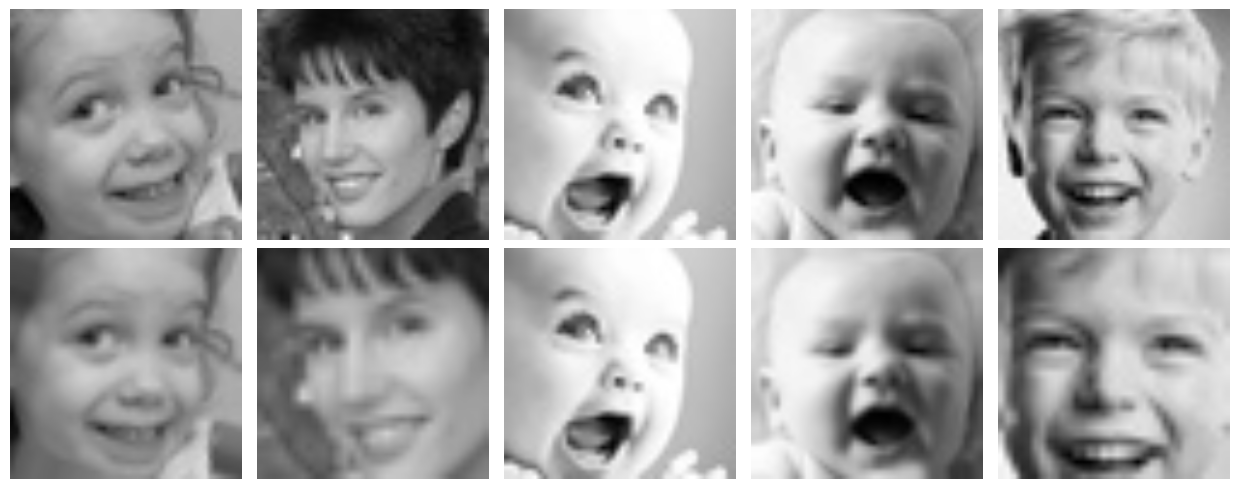

### Neutral — Antes e Depois do Pré-processamento:

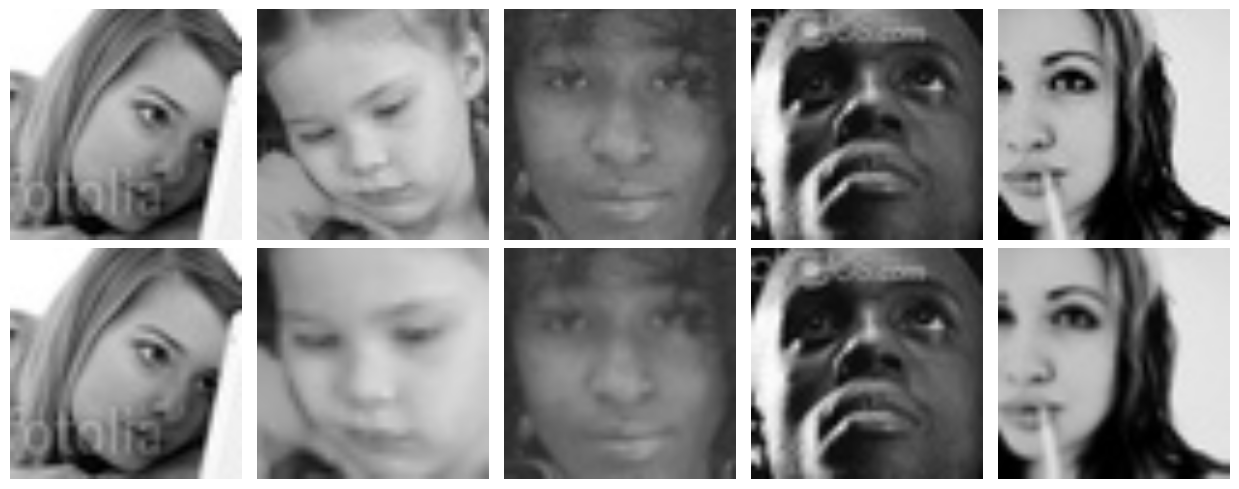

### Sad — Antes e Depois do Pré-processamento:

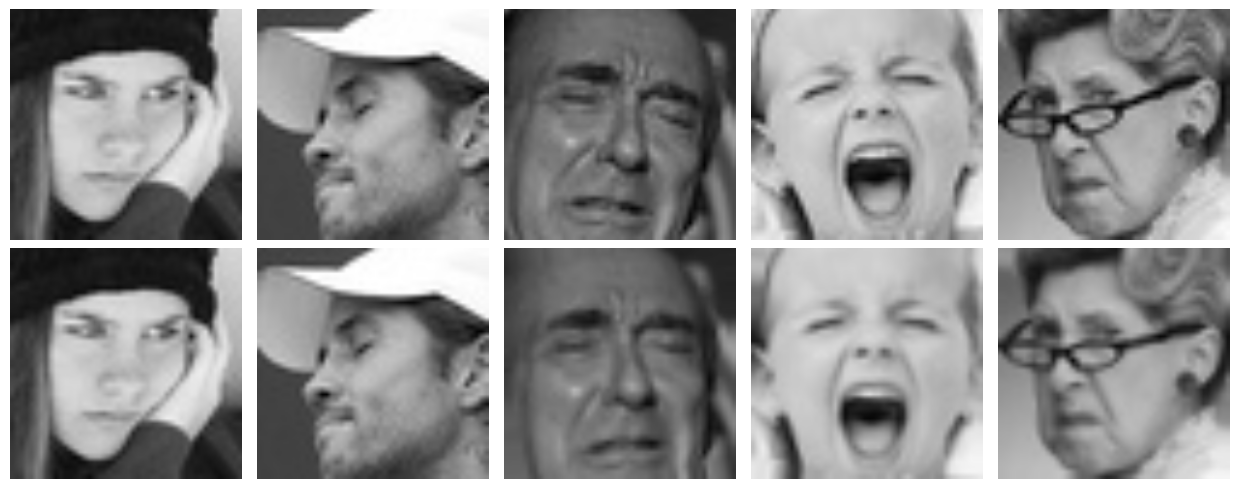

### Surprise — Antes e Depois do Pré-processamento:

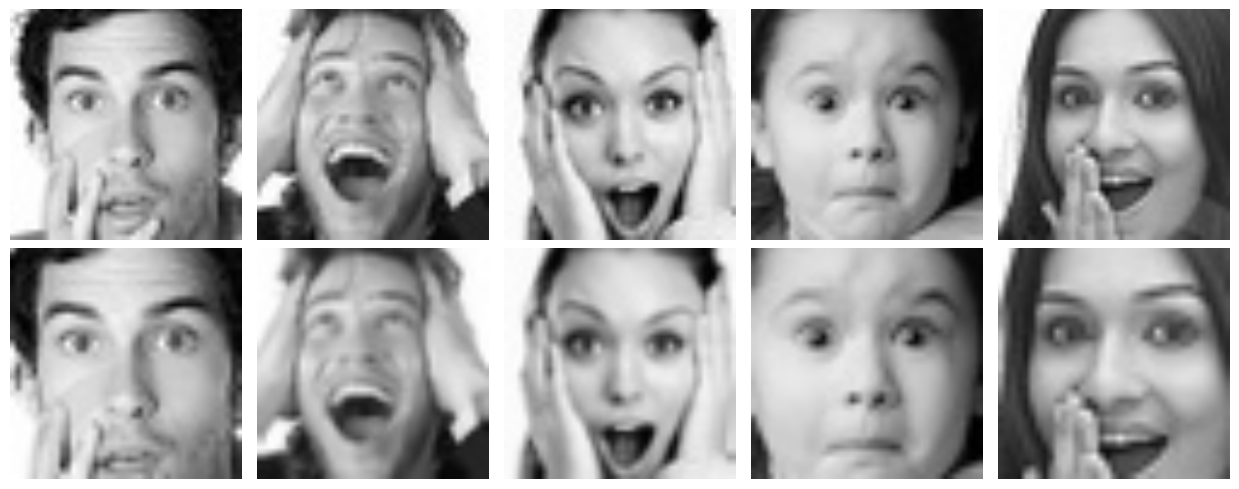

In [17]:
# Selecionar as últimas 5 imagens por classe
final_samples = 5
final_images = {label: [] for label in classes}

# Percorrer o dataset reverso para pegar as últimas imagens
for img, label in zip(reversed(X_train), reversed(y_train)):
    if len(final_images[label]) < final_samples:
        final_images[label].append(img)
    if all(len(imgs) == final_samples for imgs in final_images.values()):
        break

# Aplicar o pré-processamento
processed_images = {}

for label in classes:
    processed_images[label] = []
    for img in final_images[label]:
        processed = preprocess_pipeline(img)  # pode passar apply_equalization=True se quiser
        processed_images[label].append(processed)

# Exibir comparativo antes e depois
for label in classes:
    emotion_name = inv_label_map[label].capitalize()
    display(Markdown(f"### {emotion_name} — Antes e Depois do Pré-processamento:"))

    fig, axes = plt.subplots(2, final_samples, figsize=(final_samples * 2.5, 5))

    for i in range(final_samples):
        # Antes
        original = cv2.cvtColor(final_images[label][i], cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(original, interpolation='bilinear')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12)

        # Depois
        after = processed_images[label][i]
        after = np.clip(after * 255, 0, 255).astype(np.uint8)  # converter para visualização
        axes[1, i].imshow(after, interpolation='bilinear')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel("Processado", fontsize=12)

    plt.tight_layout()
    plt.show()


## 9. Treinamento do modelo
Nesta etapa é criado o modelo e treinamento do mesmo.

In [20]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = len(label_map)
BATCH_SIZE = 32
EPOCHS = 30

# Testando o comportamento do dataset com modelos de ML convencionais

In [16]:
#Detectar faces e extrair ROI
import cv2

def bgr_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def extract_roi(img):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    roi = img
    for (x, y, w, h) in faces:
        roi = img[y:y+h, x:x+w]
    return cv2.resize(roi, (48,48))

def resize_img(img):
    return cv2.resize(IMG_HEIGHT, IMG_WIDTH)

def flatten_img(img):
    return img.flatten()
    

In [17]:
def pipeline_for_ML_models(imgs):
    gray_scale = [bgr_to_gray(img) for img in imgs]
    # roi_images = [extract_roi(img) for img in gray_scale]
    resized_imgs = [resize_image(img) for img in gray_scale]
    flaten_imgs = [flatten_img(img) for img in resized_imgs]
    return np.array(flaten_imgs)

In [26]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train_cp = X_train.copy()
y_train_cp = y_train.copy()

X_train_processed = pipeline_for_ML_models(X_train_cp)

X_train_scaled = sc.fit_transform(X_train_processed)

In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import cv2

knn_model = KNeighborsClassifier(n_neighbors=5)



knn_model.fit(X_train_scaled, y_train_cp)

print("Modelo KNN treinado...")


Modelo KNN treinado...


In [118]:
y_preds = knn_model.predict(X_train_scaled)

accuracy_knn = accuracy_score(y_train_cp, y_preds)
print(f"Accuracy KNN: {accuracy_knn}")

python(50015) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Accuracy KNN: 0.5637256609425616


In [ ]:
#SVM
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)

svc_model.fit(X_train_scaled, y_train_cp)

print("Modelo SVC treinado...")

In [ ]:
y_preds_svc = svc_model.predict(X_train_scaled)

accuracy_svc = accuracy_score(y_train_cp, y_preds_svc)
print(f"Accuracy SVC: {accuracy_svc}")

In [17]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train_scaled, y_train_cp)

print("Modelo Random Forest treinado...")

Modelo Random Forest treinado...


In [19]:
y_preds_rf = rf_model.predict(X_train_scaled)

accuracy_rf = accuracy_score(y_train_cp, y_preds_rf)

print(f"Accuracy Random Forest: {accuracy_rf}")

Accuracy Random Forest: 0.9985022118499425


In [21]:
X_test_cp = X_test.copy()
y_test_cp = y_test.copy()

X_test_processed = pipeline_for_ML_models(X_test_cp)

X_test_scaled = sc.fit_transform(X_test_processed)

y_preds_test_rf = rf_model.predict(X_test_scaled)

accuracy_test_rf = accuracy_score(y_test_cp, y_preds_test_rf)

print(f"Accuracy Random Forest Test Dataset: {accuracy_test_rf}")

Accuracy Random Forest Test Dataset: 0.47157982724993036


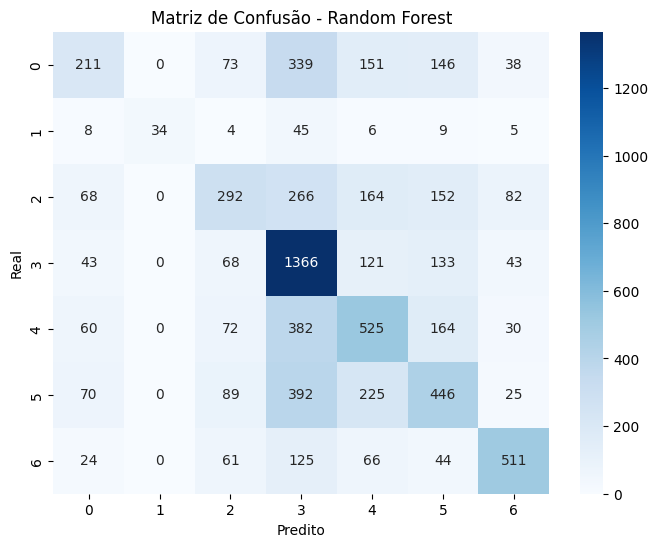

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_cp, y_preds_test_rf, labels=rf_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=rf_model.classes_,
    yticklabels=rf_model.classes_
)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=5)

rf_model.fit(X_train_scaled, y_train_cp)

print(f"Modelo Random Forest com data augmentation treinado...")

Modelo Random Forest com data augmentation treinado...


In [28]:
y_preds_rf_aug = rf_model.predict(X_train_scaled)

accuracy_rf_aug = accuracy_score(y_train_cp, y_preds_rf_aug)

print(f"Accuracy do Random Forest com Data Aug: {accuracy_rf_aug}")

Accuracy do Random Forest com Data Aug: 0.29260774201197465


In [29]:
X_test_cp = X_test.copy()
y_test_cp = y_test.copy()

X_test_processed = pipeline_for_ML_models(X_test_cp)

X_test_scaled = sc.fit_transform(X_test_processed)

y_preds_test_rf = rf_model.predict(X_test_scaled)

accuracy_test_rf = accuracy_score(y_test_cp, y_preds_test_rf)

print(f"Accuracy Random Forest Test Dataset: {accuracy_test_rf}")

Accuracy Random Forest Test Dataset: 0.25522429646140987


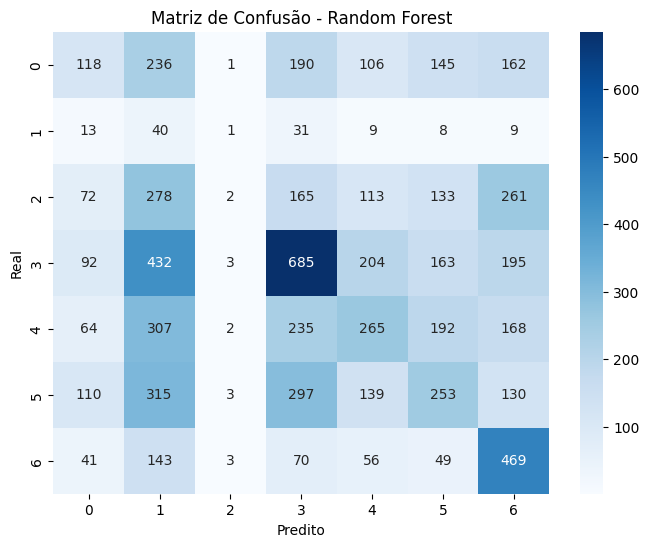

In [30]:
cm = confusion_matrix(y_test_cp, y_preds_test_rf, labels=rf_model.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=rf_model.classes_,
    yticklabels=rf_model.classes_
)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

## 9.1 Transformar as imagens em array
Primeiro passamos as imagens de treino e teste pela pipeline de pré processamento.
Em seguida, é convertida para array utilizando o np.array.
Após isso, convertemos os dados das labels em categorias utilizando a técnica one-hot, pois a ultima camada do VGG19 terá o mesmo número de categorias.

In [21]:
# Transformar X e y em arrays e converter labels para one-hot
X_train_proc = np.array([preprocess_pipeline(img) for img in X_train])
X_test_proc = np.array([preprocess_pipeline(img) for img in X_test])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)

Train shape: (50609, 224, 224, 3)
Test shape: (7178, 224, 224, 3)


## 9.2 Configuração da rede neural
O modelo base é o VGG19. A princípio, vamos congelar as camadas convolucionais para não alterar os pesos e ver como se comporta.
Na camada final, colocamos a quantidade de classes que temos para prever.

In [32]:
from keras.applications import VGG19
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 7

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │       175,623 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,200,007 (77.06 MB)

 Trainable params: 175,623 (686.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

## 9.3 Treinamento
Nesta etapa começamos o treinamento com o conjunto de treino e vemos como ele irá se sair.

In [33]:
callbacks = [
    #arlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3429 - loss: 1.6274     

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7190s 6s/step - accuracy: 0.3429 - loss: 1.6273 - val_accuracy: 0.0076 - val_loss: 9.1914
Epoch 2/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4737 - loss: 1.3776     

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7008s 6s/step - accuracy: 0.4737 - loss: 1.3776 - val_accuracy: 0.0449 - val_loss: 9.9832
Epoch 3/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7030s 6s/step - accuracy: 0.5014 - loss: 1.3066 - val_accuracy: 0.0057 - val_loss: 10.8401
Epoch 4/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5305 - loss: 1.2465     

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7795s 6s/step - accuracy: 0.5305 - loss: 1.2465 - val_accuracy: 0.0689 - val_loss: 11.0950
Epoch 5/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7632s 6s/step - accuracy: 0.5404 - loss: 1.2185 - val_accuracy: 0.0107 - val_loss: 11.8836
Epoch 6/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7493s 6s/step - accuracy: 0.5587 - loss: 1.1801 - val_accuracy: 0.0315 - val_loss: 12.1665
Epoch 7/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5721 - loss: 1.1560     

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7305s 6s/step - accuracy: 0.5721 - loss: 1.1560 - val_accuracy: 0.1069 - val_loss: 12.5186
Epoch 8/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5842 - loss: 1.1297     

1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7081s 6s/step - accuracy: 0.5842 - loss: 1.1297 - val_accuracy: 0.1353 - val_loss: 12.9536
Epoch 9/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6859s 5s/step - accuracy: 0.5950 - loss: 1.1006 - val_accuracy: 0.0544 - val_loss: 13.6468
Epoch 10/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6851s 5s/step - accuracy: 0.6040 - loss: 1.0847 - val_accuracy: 0.0999 - val_loss: 13.9000
Epoch 11/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6840s 5s/step - accuracy: 0.6103 - loss: 1.0648 - val_accuracy: 0.0604 - val_loss: 14.5660
Epoch 12/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7301s 6s/step - accuracy: 0.6175 - loss: 1.0461 - val_accuracy: 0.1181 - val_loss: 14.7700
Epoch 13/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6938s 5s/step - accuracy: 0.6189 - loss: 1.0375 - val_accuracy: 0.0664 - val_loss: 15.3787
Epoch 14/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6684s 5s/step - accuracy: 0.6324 - loss: 1.0116 - val_accuracy: 0.0806 - val_loss: 15.7334
Epoch 15/20
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6671s 5s/step - accuracy: 0.6336

In [35]:
loss, acc = model.evaluate(X_train_proc, y_train_cat, verbose=0)
print(f"Teste - Acurácia: {acc:.4f}, Loss: {loss:.4f}")

Teste - Acurácia: 0.5382, Loss: 4.3334


In [38]:
loss, acc = model.evaluate(X_test_proc, y_test_cat, verbose=0)
print(f"Teste - Acurácia: {acc:.4f}, Loss: {loss:.4f}")

Teste - Acurácia: 0.4345, Loss: 4.0191


In [22]:
# Augmented data

from keras.applications import VGG19
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 7

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [
    #EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model_augmented.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=30,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

loss, acc = model.evaluate(X_train_proc, y_train_cat, verbose=0)
print(f"Teste - Acurácia: {acc:.4f}, Loss: {loss:.4f}")

loss, acc = model.evaluate(X_test_proc, y_test_cat, verbose=0)
print(f"Teste - Acurácia: {acc:.4f}, Loss: {loss:.4f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │       175,623 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,200,007 (77.06 MB)

 Trainable params: 175,623 (686.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7465s 6s/step - accuracy: 0.3433 - loss: 1.6229 - val_accuracy: 9.8795e-05 - val_loss: 9.1874
Epoch 2/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7377s 6s/step - accuracy: 0.4776 - loss: 1.3741 - val_accuracy: 0.0144 - val_loss: 9.8452
Epoch 3/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7305s 6s/step - accuracy: 0.5074 - loss: 1.3010 - val_accuracy: 0.0464 - val_loss: 10.3878
Epoch 4/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7034s 6s/step - accuracy: 0.5278 - loss: 1.2596 - val_accuracy: 0.0400 - val_loss: 10.9539
Epoch 5/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 6884s 5s/step - accuracy: 0.5521 - loss: 1.2080 - val_accuracy: 0.0357 - val_loss: 11.5937
Epoch 6/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7105s 6s/step - accuracy: 0.5667 - loss: 1.1708 - val_accuracy: 0.0456 - val_loss: 11.9649
Epoch 7/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7008s 6s/step - accuracy: 0.5748 - loss: 1.1500 - val_accuracy: 0.1162 - val_loss: 12.2676
Epoch 8/30
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 7189s 6s/step - accuracy:

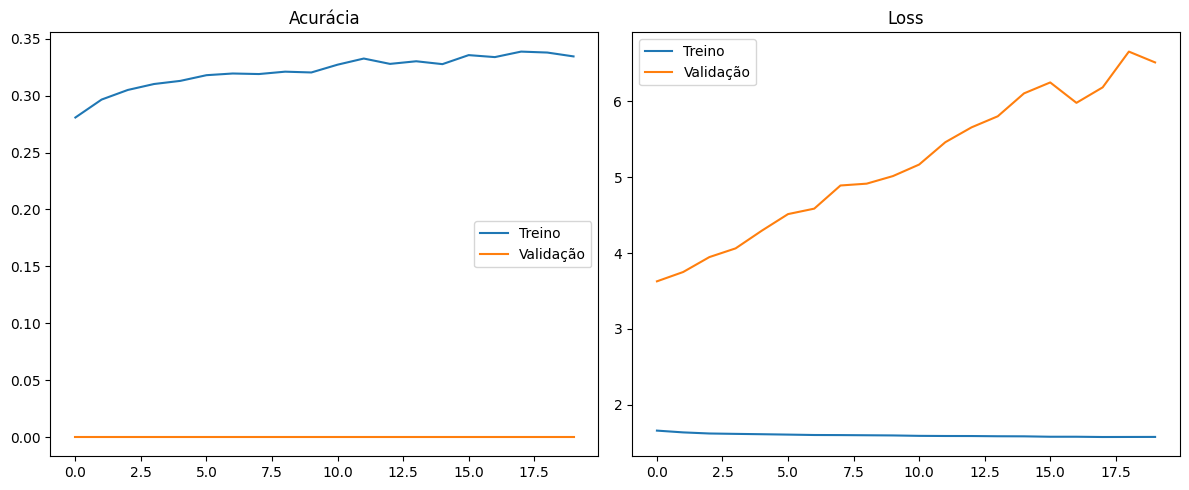

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Parâmetros ---
IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = len(label_map)
EPOCHS = 30
BATCH_SIZE = 32

# --- One-hot encoding ---
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# --- Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# --- Dividir treino e validação ---
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_proc, y_train_cat, test_size=0.2, stratify=y_train, random_state=42
)

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow(X_train_split, y_train_split, batch_size=BATCH_SIZE)

# --- Modelo com VGG19 base congelada ---
base_model = VGG19(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

# --- Treinamento ---
history = model.fit(
    train_generator,
    validation_data=(X_val_split, y_val_split),
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    steps_per_epoch=len(X_train_split) // BATCH_SIZE
)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1578 - loss: 2.1765   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1395s 2s/step - accuracy: 0.1578 - loss: 2.1764 - val_accuracy: 0.1435 - val_loss: 1.9567 - learning_rate: 1.0000e-04
Epoch 2/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 281s 391ms/step - accuracy: 0.0938 - loss: 2.2354 - val_accuracy: 0.1435 - val_loss: 1.9570 - learning_rate: 1.0000e-04
Epoch 3/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1513 - loss: 2.0353   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.1513 - loss: 2.0352 - val_accuracy: 0.1620 - val_loss: 1.9497 - learning_rate: 1.0000e-04
Epoch 4/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 281s 389ms/step - accuracy: 0.1562 - loss: 1.8437 - val_accuracy: 0.1609 - val_loss: 1.9497 - learning_rate: 1.0000e-04
Epoch 5/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.1493 - loss: 1.9807 - val_accuracy: 0.1320 - val_loss: 1.9488 - learning_rate: 1.0000e-04
Epoch 6/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 277s 385ms/step - accuracy: 0.2188 - loss: 1.6754 - val_accuracy: 0.1322 - val_loss: 1.9487 - learning_rate: 1.0000e-04
Epoch 7/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1411s 2s/step - accuracy: 0.1550 - loss: 1.9653 - val_accuracy: 0.1012 - val_loss: 1.9425 - learning_rate: 1.0000e-04
Epoch 8/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 276s 383ms/step - accuracy: 0.1562 - loss: 2.2790 - val_accuracy: 0.1008 - val_loss: 1.9425 - learning_rate: 1.0000e-04
Epoch 9/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1404s 2s/step - a

717/717 ━━━━━━━━━━━━━━━━━━━━ 1385s 2s/step - accuracy: 0.1819 - loss: 1.9305 - val_accuracy: 0.1701 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 20/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 18:09 2s/step - accuracy: 0.2188 - loss: 1.5805

717/717 ━━━━━━━━━━━━━━━━━━━━ 272s 377ms/step - accuracy: 0.2188 - loss: 1.5805 - val_accuracy: 0.1708 - val_loss: 1.8979 - learning_rate: 1.0000e-04
Epoch 21/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1392s 2s/step - accuracy: 0.1903 - loss: 1.9117 - val_accuracy: 0.1379 - val_loss: 1.8968 - learning_rate: 1.0000e-04
Epoch 22/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 286s 398ms/step - accuracy: 0.0625 - loss: 1.7077 - val_accuracy: 0.1395 - val_loss: 1.8968 - learning_rate: 1.0000e-04
Epoch 23/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1661 - loss: 1.9326   

717/717 ━━━━━━━━━━━━━━━━━━━━ 1398s 2s/step - accuracy: 0.1661 - loss: 1.9325 - val_accuracy: 0.2335 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 24/30
  1/717 ━━━━━━━━━━━━━━━━━━━━ 18:41 2s/step - accuracy: 0.1562 - loss: 2.1157

717/717 ━━━━━━━━━━━━━━━━━━━━ 284s 395ms/step - accuracy: 0.1562 - loss: 2.1157 - val_accuracy: 0.2346 - val_loss: 1.8846 - learning_rate: 1.0000e-04
Epoch 25/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1392s 2s/step - accuracy: 0.1827 - loss: 1.9038 - val_accuracy: 0.1910 - val_loss: 1.8824 - learning_rate: 1.0000e-04
Epoch 26/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 271s 377ms/step - accuracy: 0.1250 - loss: 2.0148 - val_accuracy: 0.1907 - val_loss: 1.8823 - learning_rate: 1.0000e-04
Epoch 27/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1417s 2s/step - accuracy: 0.1894 - loss: 1.8959 - val_accuracy: 0.2252 - val_loss: 1.8788 - learning_rate: 1.0000e-04
Epoch 28/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 275s 381ms/step - accuracy: 0.2812 - loss: 1.6363 - val_accuracy: 0.2269 - val_loss: 1.8788 - learning_rate: 1.0000e-04
Epoch 29/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 1324s 2s/step - accuracy: 0.1953 - loss: 1.8858 - val_accuracy: 0.2224 - val_loss: 1.8745 - learning_rate: 1.0000e-04
Epoch 30/30
717/717 ━━━━━━━━━━━━━━━━━━━━ 261s 362ms/

In [39]:
import os
import cv2
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

# Caminho original
train_path = os.path.join(destination_path, "train")

# Contar imagens por classe
class_counts = {class_name: len(os.listdir(os.path.join(train_path, class_name)))
                for class_name in os.listdir(train_path)}
max_count = max(class_counts.values())

print("Distribuição original:", class_counts)

# Gerador com algumas transformações comuns
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Função para aumentar imagens de uma classe
def augment_class(class_name, target_count):
    class_dir = os.path.join(train_path, class_name)
    images = []

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)

    images = np.array(images)
    images = images.astype("float32") / 255.0  # Normaliza se necessário

    n_to_generate = target_count - len(images)
    generated = 0
    batch_size = 32

    # Gera imagens usando o generator
    for x_batch in datagen.flow(images, batch_size=batch_size, save_to_dir=class_dir,
                                save_prefix="aug", save_format="png"):
        generated += len(x_batch)
        if generated >= n_to_generate:
            break

# Aumentar classes minoritárias
for class_name, count in class_counts.items():
    if count < max_count:
        print(f"Aumentando classe '{class_name}' de {count} para {max_count}")
        augment_class(class_name, max_count)

Distribuição original: {'happy': 7215, 'sad': 4830, 'fear': 4097, 'surprise': 3171, 'neutral': 4965, 'angry': 3995, 'disgust': 436}
Aumentando classe 'sad' de 4830 para 7215
Aumentando classe 'fear' de 4097 para 7215
Aumentando classe 'surprise' de 3171 para 7215
Aumentando classe 'neutral' de 4965 para 7215
Aumentando classe 'angry' de 3995 para 7215
Aumentando classe 'disgust' de 436 para 7215


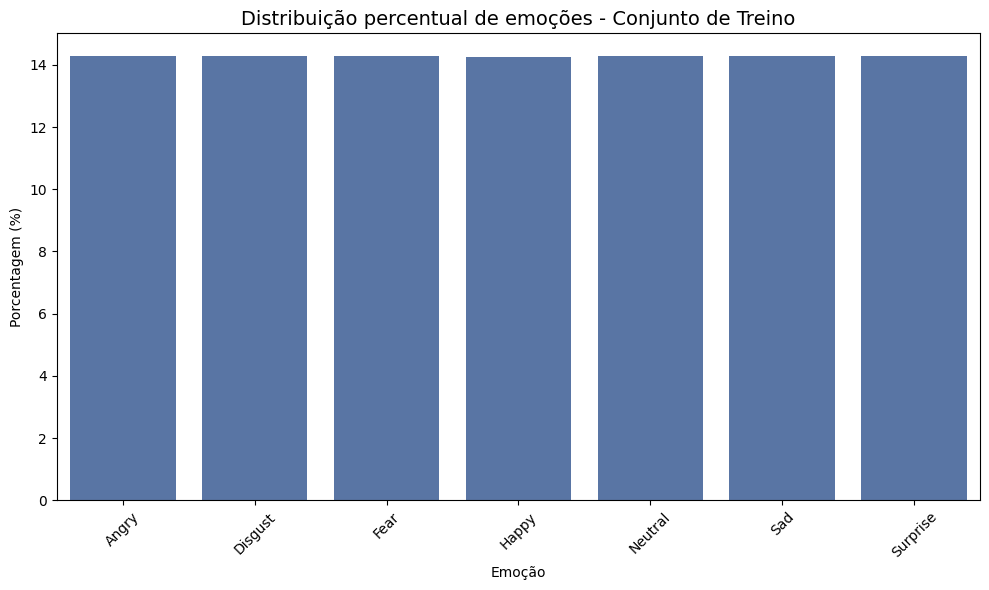

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Inverter o mapeamento de labels
inv_label_map = {v: k for k, v in label_map.items()}

# Reaproveitar a função de distribuição
def get_distribution(labels):
    count_series = pd.Series(labels).value_counts().sort_index()
    count_df = pd.DataFrame({
        'Emoção': [inv_label_map[i].capitalize() for i in count_series.index],
        'Quantidade': count_series.values,
    })
    total = count_df['Quantidade'].sum()
    count_df['Porcentagem'] = (count_df['Quantidade'] / total * 100).round(2)
    return count_df

# Obter distribuição apenas do treino
df_train = get_distribution(y_train)

# Gráfico de barras (somente treino)
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Emoção',
    y='Porcentagem',
    palette=['#4C72B0']
)

plt.title("Distribuição percentual de emoções - Conjunto de Treino", fontsize=14)
plt.ylabel("Porcentagem (%)")
plt.xlabel("Emoção")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Transformar X e y em arrays e converter labels para one-hot
X_train_proc = np.array([preprocess_pipeline(img) for img in X_train])
X_test_proc = np.array([preprocess_pipeline(img) for img in X_test])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)

# Carrega a base do VGG19 sem a camada de classificação final
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congela as camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Adiciona as camadas finais customizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [
    #arlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Train shape: (50800, 224, 224, 3)
Test shape: (7178, 224, 224, 3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
1270/1270 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1720 - loss: 2.0226   

1270/1270 ━━━━━━━━━━━━━━━━━━━━ 2447s 2s/step - accuracy: 0.1721 - loss: 2.0225 - val_accuracy: 0.0000e+00 - val_loss: 3.7700
Epoch 2/20
  12/1270 ━━━━━━━━━━━━━━━━━━━━ 29:48 1s/step - accuracy: 0.1940 - loss: 1.8061  

In [25]:
def preprocess_pipeline_basic(image, apply_equalization=False):
    """
    Aplica a sequência completa de pré-processamento:
    1. Conversão para RGB
    2. Redimensionamento para 224x224
    Retorna a imagem pronta para entrada na rede neural.
    """

    # 1. Garantir que está em RGB
    image = to_rgb(image)

    # 2. Redimensionamento
    image = resize_image(image, size=(224, 224))


    return image

In [29]:
# treinamento sem pre processar a imagem
# Transformar X e y em arrays e converter labels para one-hot
X_train_proc = np.array([preprocess_pipeline_basic(img) for img in X_train])
X_test_proc = np.array([preprocess_pipeline_basic(img) for img in X_test])

y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("Train shape:", X_train_proc.shape)
print("Test shape:", X_test_proc.shape)

# Carrega a base do VGG19 sem a camada de classificação final
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congela as camadas convolucionais
for layer in base_model.layers:
    layer.trainable = False

# Adiciona as camadas finais customizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

callbacks = [
    ModelCheckpoint('best_vgg19_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train_proc, y_train_cat,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

(28709, 7)
Train shape: (28709, 224, 224, 3)
Test shape: (7178, 224, 224, 3)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,090,951 (76.64 MB)

 Trainable params: 66,567 (260.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2191 - loss: 5.7696   

718/718 ━━━━━━━━━━━━━━━━━━━━ 3874s 5s/step - accuracy: 0.2191 - loss: 5.7676 - val_accuracy: 0.0091 - val_loss: 4.9828
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3601s 5s/step - accuracy: 0.2621 - loss: 2.3070 - val_accuracy: 3.4831e-04 - val_loss: 4.5034
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3598s 5s/step - accuracy: 0.2839 - loss: 1.8013 - val_accuracy: 1.7416e-04 - val_loss: 5.6422
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3584s 5s/step - accuracy: 0.2964 - loss: 1.6836 - val_accuracy: 0.0000e+00 - val_loss: 6.4222
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3579s 5s/step - accuracy: 0.3145 - loss: 1.6301 - val_accuracy: 0.0000e+00 - val_loss: 7.2037
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3563s 5s/step - accuracy: 0.3293 - loss: 1.6105 - val_accuracy: 0.0000e+00 - val_loss: 7.7983
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3563s 5s/step - accuracy: 0.3372 - loss: 1.5882 - val_accuracy: 0.0000e+00 - val_loss: 8.2176
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 3556s 5s/step - accuracy: 0.3455 - lo

In [31]:
from sklearn.metrics import accuracy_score

train_pred = model.predict(X_train_proc)
accuracy = accuracy_score(y_train, train_pred)

print(f"Accuracy: {accuracy}")

898/898 ━━━━━━━━━━━━━━━━━━━━ 7244s 8s/step   


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [32]:
train_pred

array([[2.5020579e-01, 5.7583963e-03, 3.1199026e-01, ..., 1.5318368e-01,
        6.9370784e-02, 6.8443762e-12],
       [1.9182587e-01, 3.6844211e-03, 5.8874190e-02, ..., 2.6231638e-01,
        6.2371410e-02, 5.5666788e-10],
       [2.1266055e-01, 2.8855694e-02, 2.5331992e-01, ..., 1.4509529e-01,
        1.8385464e-01, 2.6439759e-05],
       ...,
       [1.8222512e-01, 1.6032809e-02, 3.7362641e-01, ..., 1.8216263e-01,
        8.6885780e-02, 9.4562180e-10],
       [2.3361249e-01, 1.6111493e-02, 3.7891614e-01, ..., 1.4301413e-01,
        8.8985130e-02, 6.5091987e-11],
       [1.2929493e-01, 1.1469487e-02, 2.2278862e-01, ..., 3.9100581e-01,
        6.9638565e-02, 5.5372557e-11]], dtype=float32)